### Comparison between CNNs with and without SE-blocks and Multilayer Perceptron for Facial Emotion Recognition

This notebook compares three neural network architectures for facial emotion recognition. Running the full notebook requires training neural networks and may involve long runtimes.

In [1]:
import numpy as np

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import pandas as pd

from src.cnn import CNN
from src.mlp import MLP
from src.datamanager import DataManager
from src.training import train_model
from src.plotting import betaplotter, etaplotter, confusion_plotter
from src.transformations import ToTensorSample, NormalizeSample

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.rcParams.update({"font.size": 15})

seed = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Preparing the data.

In [ ]:
labels_filename = "../Dataset/list_patition_label.txt"  #  Must include path
labels = pd.read_csv(
    labels_filename, 
    sep=" ", 
    header=None, 
    names=["filename", "emolabel"]
    )

# Using the built in train-test split 
train_labels_full = labels[labels["filename"].str.startswith("train")].reset_index(drop=True)
test_labels  = labels[labels["filename"].str.startswith("test")].reset_index(drop=True)

# Transforms data to pytorch tensors and normalizes
transform = transforms.Compose([
    ToTensorSample(),
    NormalizeSample(),  
])

# Splitting original train into train + validation
train_labels, val_labels = train_test_split(
    train_labels_full,
    test_size=0.2,
    random_state=seed,
    stratify=train_labels_full["emolabel"]
)

dataset_dir = "../Dataset/aligned/"    #  Path to folder containing images

train_data = DataManager(train_labels, dataset_dir, transform)
val_data = DataManager(val_labels, dataset_dir, transform)
test_data = DataManager(test_labels, dataset_dir, transform)

Defining training variables. They will be used in the rest of the notebook.

In [ ]:
epochs = 8  

batch_size = 128

# Data loaders for shuffling and minibatch sampling
rng = torch.Generator()  #  Random number generator to seed the data loaders.
rng.manual_seed(seed)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, generator=rng)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, generator=rng)

Training model once to make runtime estimates. 

In [ ]:
"""Long runtime, may be skipped"""
CNN_plain = CNN(sq_ex=False).to(device)
CNN_sqex = CNN(sq_ex=True).to(device)
MultiLP = MLP().to(device)

acc_CNNP = train_model(device, CNN_plain, train_loader, val_loader, lr=1e-3, beta1=0.9, beta2=0.999, num_epochs=epochs, verbose=True)
acc_CNNS = train_model(device, CNN_sqex, train_loader, val_loader, lr=1e-3, beta1=0.9, beta2=0.999, num_epochs=epochs, verbose=True)
acc_MLP = train_model(device, MultiLP, train_loader, val_loader, lr=1e-3, beta1=0.9, beta2=0.999, num_epochs=epochs, verbose=True)

print(f"accuracy CNN SqEx: {acc_CNNS:.2f}")
print(f"accuracy CNN plain: {acc_CNNP:.2f}")
print(f"accuracy MLP: {acc_MLP:.2f}")

Grid search of `eta`, `beta1` and `beta2`.

In [ ]:
"""The whole grid search will take about 140 times (len beta1 * len beta2 * len lr) longer than the cell above. 
If this is too long, remove some learning rates or lower epochs."""

# Shared for all three searches
beta1_values = [0.7, 0.8, 0.9, 0.95, 0.99]
beta2_values = [0.8, 0.9, 0.99, 0.999]
learning_rates = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]

adam_accuracies_MLP = np.zeros((len(beta1_values), len(beta2_values), len(learning_rates)))
adam_accuracies_CNNP = np.zeros((len(beta1_values), len(beta2_values), len(learning_rates)))
adam_accuracies_CNNS = np.zeros((len(beta1_values), len(beta2_values), len(learning_rates)))

In [ ]:
"""Long runtime, may be skipped"""
# CNN with squeeze excitation (trains the slowest)
for i, b1 in enumerate(beta1_values):
    for j, b2 in enumerate(beta2_values):
        for k, eta in enumerate(learning_rates):
            print(f"\nTraining CNN w/ Sq-Ex with lr={eta}, beta1={b1}, beta2={b2}")
            model = CNN(sq_ex=True).to(device)
            acc = train_model(device, model, train_loader, val_loader, lr=eta, beta1=b1, beta2=b2, num_epochs=epochs, verbose=False)
            adam_accuracies_CNNS[i, j, k] = acc
            # adam_accuracies_CNNS[i, j, k] = np.random.randn()

# Restructure data and save to file
rows = []
for i, b1 in enumerate(beta1_values):
    for j, b2 in enumerate(beta2_values):
        for k, eta in enumerate(learning_rates):
            rows.append({
                "beta1": b1,
                "beta2": b2,
                "learning_rate": eta,
                "accuracy": adam_accuracies_CNNS[i, j, k],
            })

adam_grid_df = pd.DataFrame(rows)
adam_grid_df.to_csv("../saved_data/adam_grid_CNN_SqEx.csv", index=False)
adam_grid_df

In [ ]:
"""Long runtime, may be skipped"""
# plain CNN 
for i, b1 in enumerate(beta1_values):
    for j, b2 in enumerate(beta2_values):
        for k, eta in enumerate(learning_rates):
            print(f"\nTraining plain CNN with lr={eta}, beta1={b1}, beta2={b2}")
            model = CNN(sq_ex=False).to(device)
            acc = train_model(device, model, train_loader, val_loader, lr=eta, beta1=b1, beta2=b2, num_epochs=epochs, verbose=False)
            adam_accuracies_CNNP[i, j, k] = acc
        
            # adam_accuracies_CNNP[i, j, k] = np.random.randn()

# Restructure data and save to file
rows = []
for i, b1 in enumerate(beta1_values):
    for j, b2 in enumerate(beta2_values):
        for k, eta in enumerate(learning_rates):
            rows.append({
                "beta1": b1,
                "beta2": b2,
                "learning_rate": eta,
                "accuracy": adam_accuracies_CNNP[i, j, k],
            })

adam_grid_df = pd.DataFrame(rows)
adam_grid_df.to_csv("../saved_data/adam_grid_CNN_plain.csv", index=False)
adam_grid_df

In [ ]:
"""Long runtime, may be skipped"""
# MLP
for i, b1 in enumerate(beta1_values):
    for j, b2 in enumerate(beta2_values):
        for k, eta in enumerate(learning_rates):
            print(f"\nTraining MLP with lr={eta}, beta1={b1}, beta2={b2}")
            model = MLP().to(device)
            acc = train_model(device, model, train_loader, val_loader, lr=eta, beta1=b1, beta2=b2, num_epochs=epochs, verbose=False)
            adam_accuracies_MLP[i, j, k] = acc
            
            # adam_accuracies_MLP[i, j, k] = np.random.randn()

# Restructure data and save to file
rows = []
for i, b1 in enumerate(beta1_values):
    for j, b2 in enumerate(beta2_values):
        for k, eta in enumerate(learning_rates):
            rows.append({
                "beta1": b1,
                "beta2": b2,
                "learning_rate": eta,
                "accuracy": adam_accuracies_MLP[i, j, k],
            })

adam_grid_df = pd.DataFrame(rows)
adam_grid_df.to_csv("../saved_data/adam_grid_mlp.csv", index=False)
adam_grid_df

Retrieving data to work with it without needing to run the grid search again.

In [9]:
# Read from CSV
adam_grid_df_CNNS = pd.read_csv("../saved_data/adam_grid_CNN_SqEx_8e.csv")

adam_grid_CNNS = adam_grid_df_CNNS["accuracy"].values.reshape(
    len(beta1_values),
    len(beta2_values),
    len(learning_rates),
)

adam_grid_df_CNNP = pd.read_csv("../saved_data/adam_grid_CNN_plain_8e.csv")

adam_grid_CNNP = adam_grid_df_CNNP["accuracy"].values.reshape(
    len(beta1_values),
    len(beta2_values),
    len(learning_rates),
)

adam_grid_df_MLP = pd.read_csv("../saved_data/adam_grid_mlp_8e.csv")

adam_grid_MLP = adam_grid_df_MLP["accuracy"].values.reshape(
    len(beta1_values),
    len(beta2_values),
    len(learning_rates),
)

print(type(adam_grid_CNNS), np.shape(adam_grid_CNNS))

<class 'numpy.ndarray'> (5, 4, 7)


In [10]:
best_params_idx_CNNS = adam_grid_df_CNNS["accuracy"].idxmax()
best_adam_par_CNNS = adam_grid_df_CNNS.loc[best_params_idx_CNNS]

best_params_idx_CNNP = adam_grid_df_CNNP["accuracy"].idxmax()
best_adam_par_CNNP = adam_grid_df_CNNP.loc[best_params_idx_CNNP]

best_params_idx_MLP = adam_grid_df_MLP["accuracy"].idxmax()
best_adam_par_MLP = adam_grid_df_MLP.loc[best_params_idx_MLP]


In [11]:
best_adam_par_CNNS

beta1             0.950000
beta2             0.990000
learning_rate     0.001000
accuracy         73.727088
Name: 104, dtype: float64

In [12]:
best_adam_par_CNNP

beta1             0.800000
beta2             0.900000
learning_rate     0.001000
accuracy         75.397149
Name: 41, dtype: float64

In [13]:
best_adam_par_MLP

beta1             0.700000
beta2             0.900000
learning_rate     0.000100
accuracy         67.372709
Name: 11, dtype: float64

Plotting accuracy heatmap of `beta1` and `beta2` in the slice of best learning rate.

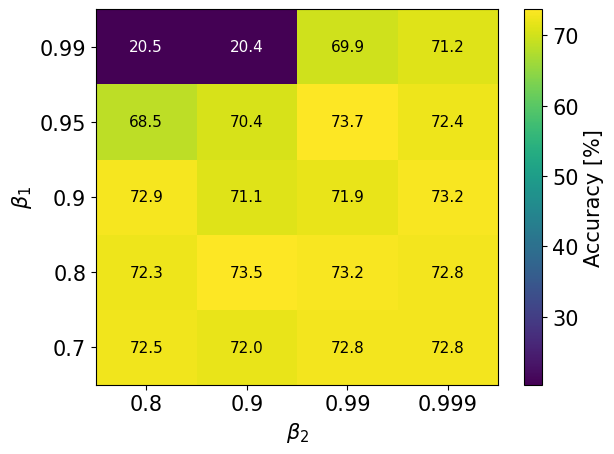

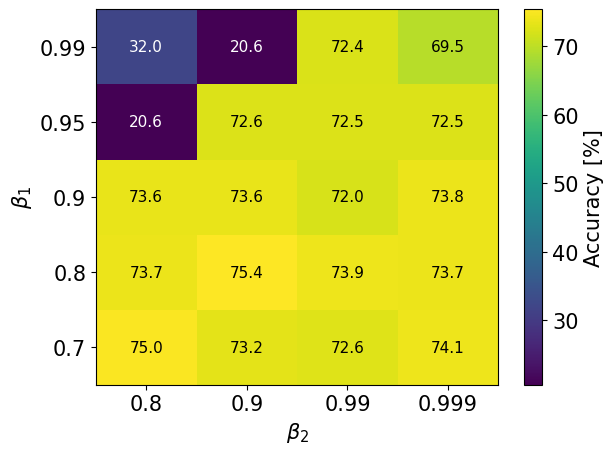

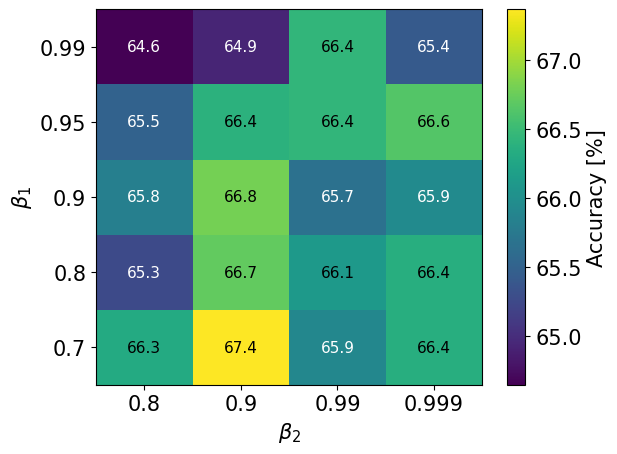

In [14]:
betaplotter(best_adam_par_CNNS, learning_rates, beta1_values, beta2_values, adam_grid_CNNS, "../Figures/adam_betas_CNN_SqEq.pdf")
betaplotter(best_adam_par_CNNP, learning_rates, beta1_values, beta2_values, adam_grid_CNNP, "../Figures/adam_betas_CNN_plain.pdf")
betaplotter(best_adam_par_MLP, learning_rates, beta1_values, beta2_values, adam_grid_MLP, "../Figures/adam_betas_mlp.pdf")

Plotting learning rate validation accuracy in slice of best $\beta_1$ and $\beta_2$.

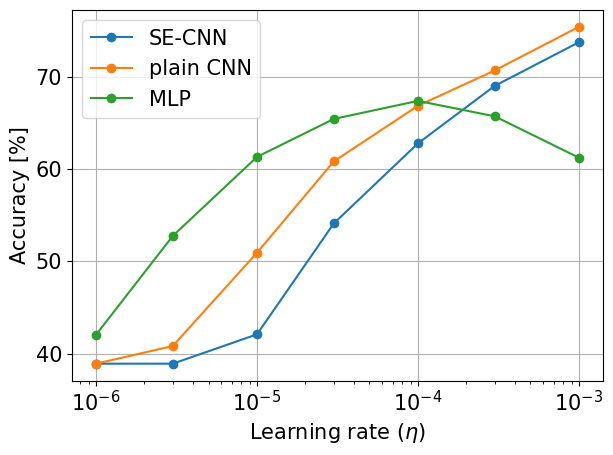

In [ ]:
# Plotting etas in slice of best betas

models = [
    {
        "name": "SE-CNN",
        "best_params": best_adam_par_CNNS,
        "accuracy_grid": adam_grid_CNNS,
    },
    {
        "name": "plain CNN",
        "best_params": best_adam_par_CNNP,
        "accuracy_grid": adam_grid_CNNP,
    },
    {
        "name": "MLP",
        "best_params": best_adam_par_MLP,
        "accuracy_grid": adam_grid_MLP,
    },
]

etaplotter(models, learning_rates, beta1_values, beta2_values,"../Figures/eta_comparison.pdf",)

Tuning dropout rate.

In [ ]:
# Loading best Adam paramers
best_lr_CNNS = best_adam_par_CNNS["learning_rate"]
best_beta1_CNNS = best_adam_par_CNNS["beta1"]
best_beta2_CNNS = best_adam_par_CNNS["beta2"]

best_lr_MLP = best_adam_par_MLP["learning_rate"]
best_beta1_MLP = best_adam_par_MLP["beta1"]
best_beta2_MLP = best_adam_par_MLP["beta2"]

best_lr_CNNP = best_adam_par_CNNP["learning_rate"]
best_beta1_CNNP = best_adam_par_CNNP["beta1"]
best_beta2_CNNP = best_adam_par_CNNP["beta2"]

# Defining dropout rates to evaluate, and arrays to store the results
drop_rates = np.linspace(0, 0.8, 17)
dr_accuracies_CNNS = np.zeros_like(drop_rates)
dr_accuracies_CNNP = np.zeros_like(drop_rates)
dr_accuracies_MLP = np.zeros_like(drop_rates)


In [ ]:
"""Long runtime, may be skipped"""
# CNNS
for i, dr in enumerate(drop_rates):
    print(f"\nTraining with dropout rate = {dr}")
    model = CNN(sq_ex=True, dr_rate=dr).to(device)
    acc = train_model(device, model, train_loader, val_loader, lr=best_lr_CNNS, beta1=best_beta1_CNNS, beta2=best_beta2_CNNS, num_epochs=epochs, verbose=True)
    # acc = np.random.randn()
    dr_accuracies_CNNS[i] = acc
    print(f"Validation accuracy for dr={dr}: {acc:.2f}%")

# Save data
dr_dict = {
    "dropout rates": drop_rates,
    "dr accuracies": dr_accuracies_CNNS
}

lr_df = pd.DataFrame(dr_dict)
lr_df.to_csv("../saved_data/dr_CNN_SqEx.csv", index=False)
lr_df

In [ ]:
"""Long runtime, may be skipped"""
# CNNP
for i, dr in enumerate(drop_rates):
    print(f"\nTraining with dropout rate = {dr}")
    model = CNN(sq_ex=False, dr_rate=dr).to(device)
    acc = train_model(device, model, train_loader, val_loader, lr=best_lr_CNNP, beta1=best_beta1_CNNP, beta2=best_beta2_CNNP, dr_rate=dr, num_epochs=epochs, verbose=True)
    # acc = np.random.randn()
    dr_accuracies_CNNP[i] = acc
    print(f"Validation accuracy for dr={dr}: {acc:.2f}%")

# Save data
dr_dict = {
    "dropout rates": drop_rates,
    "dr accuracies": dr_accuracies_CNNP
}

lr_df = pd.DataFrame(dr_dict)
lr_df.to_csv("../saved_data/dr_CNN_plain.csv", index=False)
lr_df

In [ ]:
"""Long runtime, may be skipped"""
# MLP
for i, dr in enumerate(drop_rates):
    print(f"\nTraining with dropout rate = {dr}")
    model=MLP(dr_rate=dr).to(device)
    acc = train_model(device, model, train_loader, val_loader, lr=best_lr_MLP, beta1=best_beta1_MLP, beta2=best_beta2_MLP, dr_rate=dr, num_epochs=epochs, verbose=True)
    # acc = np.random.randn()
    dr_accuracies_MLP[i] = acc
    print(f"Validation accuracy for dr={dr}: {acc:.2f}%")

# Save data
dr_dict = {
    "dropout rates": drop_rates,
    "dr accuracies": dr_accuracies_MLP
}

lr_df = pd.DataFrame(dr_dict)
lr_df.to_csv("../saved_data/dr_mlp.csv", index=False)
lr_df

In [ ]:
# Loading saved results from dropout rate search
dr_accs_CNNS = pd.read_csv("../saved_data/dr_CNN_SqEx_8e.csv")
dr_accs_CNNP = pd.read_csv("../saved_data/dr_CNN_plain_8e.csv")
dr_accs_MLP = pd.read_csv("../saved_data/dr_mlp_8e.csv")

dr_best_CNNS_idx = dr_accs_CNNS["dr accuracies"].idxmax()
dr_best_CNNS = dr_accs_CNNS.loc[dr_best_CNNS_idx]["dropout rates"]

dr_best_CNNP_idx = dr_accs_CNNP["dr accuracies"].idxmax()
dr_best_CNNP = dr_accs_CNNP.loc[dr_best_CNNP_idx]["dropout rates"]

dr_best_MLP_idx = dr_accs_MLP["dr accuracies"].idxmax()
dr_best_MLP = dr_accs_MLP.loc[dr_best_MLP_idx]["dropout rates"]

dr_best_CNNS

np.float64(0.35)

In [18]:
dr_best_CNNP

np.float64(0.45)

In [19]:
dr_best_MLP

np.float64(0.3)

Plotting results from dropout rate tuning.

SE-CNN : best accuracy = 73.2% at dropout rate = 0.35
plain CNN : best accuracy = 75.0% at dropout rate = 0.45
MLP : best accuracy = 67.9% at dropout rate = 0.30


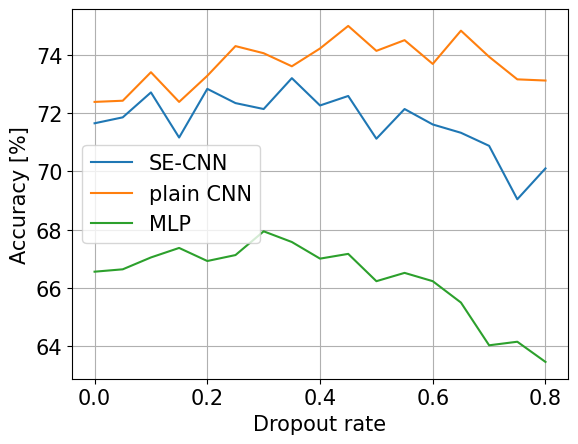

In [21]:
acc_best_CNNS = dr_accs_CNNS.loc[dr_best_CNNS_idx, "dr accuracies"]
acc_best_CNNP = dr_accs_CNNP.loc[dr_best_CNNP_idx, "dr accuracies"]
acc_best_MLP = dr_accs_MLP.loc[dr_best_MLP_idx, "dr accuracies"]

print(f"SE-CNN : best accuracy = {acc_best_CNNS:.1f}% at dropout rate = {dr_best_CNNS:.2f}")
print(f"plain CNN : best accuracy = {acc_best_CNNP:.1f}% at dropout rate = {dr_best_CNNP:.2f}")
print(f"MLP : best accuracy = {acc_best_MLP:.1f}% at dropout rate = {dr_best_MLP:.2f}")

plt.plot(drop_rates, dr_accs_CNNS["dr accuracies"], label="SE-CNN")
plt.plot(drop_rates, dr_accs_CNNP["dr accuracies"], label="plain CNN")
plt.plot(drop_rates, dr_accs_MLP["dr accuracies"], label="MLP")
plt.xlabel("Dropout rate")
plt.ylabel("Accuracy [%]")
plt.grid()
plt.legend()
plt.savefig("../Figures/dropout_comparison.pdf", bbox_inches="tight")

Evaluating tuned models on test data, training on the full training set.

In [ ]:
full_train_data = DataManager(train_labels_full, dataset_dir, transform)

rng = torch.Generator()
rng.manual_seed(seed)

full_train_loader = DataLoader(full_train_data, batch_size=batch_size, shuffle=True, generator=rng)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, generator=rng)

In [ ]:
"""Long runtime, may be skipped"""
# Train models with best hyperparameters
tuned_CNNS = CNN(sq_ex=True, dr_rate=dr_best_CNNS).to(device)
tuned_CNNP = CNN(sq_ex=False, dr_rate=dr_best_CNNP).to(device)
tuned_MLP = MLP(dr_rate=dr_best_MLP).to(device)

cnns_acc = train_model(
    device, 
    tuned_CNNS, 
    full_train_loader, 
    test_loader, 
    best_lr_CNNS, 
    best_beta1_CNNS, 
    best_beta2_CNNS, 
    epochs, 
    verbose=True
    )

cnnp_acc = train_model(
    device, 
    tuned_CNNP, 
    full_train_loader, 
    test_loader, 
    best_lr_CNNP, 
    best_beta1_CNNP, 
    best_beta2_CNNP, 
    epochs, 
    verbose=True
    )

mlp_acc = train_model(
    device, 
    tuned_MLP, 
    full_train_loader, 
    test_loader, 
    best_lr_MLP, 
    best_beta1_MLP, 
    best_beta2_MLP, 
    epochs, 
    verbose=True
    )

# Saving the trained parameters to file
torch.save(tuned_CNNS.state_dict(), "../trained_states/CNN_SqEx_tuned.pt") 
torch.save(tuned_CNNP.state_dict(), "../trained_states/CNN_plain_tuned.pt") 
torch.save(tuned_MLP.state_dict(), "../trained_states/mlp_tuned.pt") 

Loading trained models.

In [20]:
cnns_trained = CNN(sq_ex=True, dr_rate=dr_best_CNNS).to(device)
cnns_trained.load_state_dict(torch.load("../trained_states/CNN_SqEx_tuned.pt"))

cnnp_trained = CNN(sq_ex=False, dr_rate=dr_best_CNNP).to(device)
cnnp_trained.load_state_dict(torch.load("../trained_states/CNN_plain_tuned.pt"))

mlp_trained = MLP(dr_rate=dr_best_MLP).to(device)
mlp_trained.load_state_dict(torch.load("../trained_states/mlp_tuned.pt"))

<All keys matched successfully>

Plotting confusion matrix for the three models. Note that `confusion_plotter` generates predictions with the models on the test set, so the runtime is somewhat high (a couple of minutes on laptop).

Test Accuracy: 74.22%


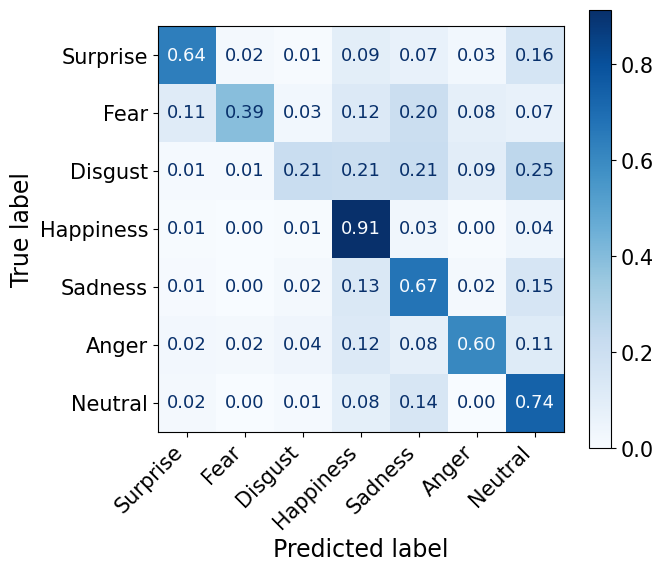

Test Accuracy: 76.60%


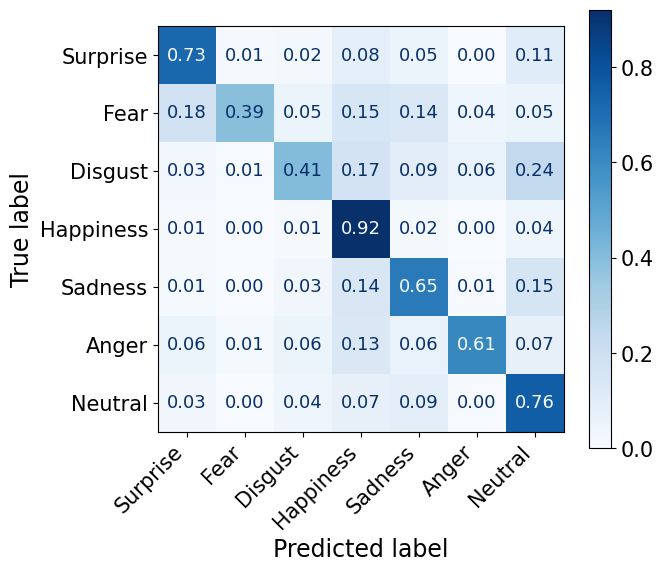

Test Accuracy: 68.87%


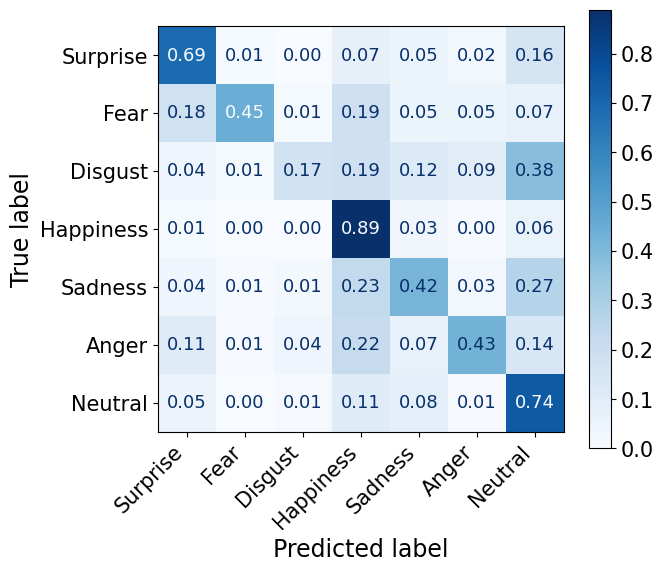

In [21]:
confusion_plotter(cnns_trained, test_loader, device, "../Figures/confusion_CNN_SqEx.pdf")
confusion_plotter(cnnp_trained, test_loader, device, "../Figures/confusion_CNN_plain.pdf")
confusion_plotter(mlp_trained, test_loader, device, "../Figures/confusion_mlp.pdf")